In [68]:
%load_ext autoreload
%autoreload 2

import numpy as np

from functions.data_loading import flights_from_query, get_flight_persistances
from functions.objects import PersistenceData, Models

from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import balanced_accuracy_score, root_mean_squared_error

from traffic.core import Traffic, Flight

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
datasets = [("unbalanced", True, True),("unbalanced", False, False),("balanced", False, False)]
name, simple, classification = datasets[1]

In [70]:
train_name = f"{name}_train"
test_name = f"{name}_test"

flights_train, data_train, B_train = flights_from_query(None, train_name, load_results=True)
flights_test, data_test, B_test = flights_from_query(None, test_name, load_results=True)

pers_train = get_flight_persistances(flights_train, train_name, load_results=True)
LL_train, A_train, S_train, H_train = pers_train
pers_test = get_flight_persistances(flights_test, test_name, load_results=True)
LL_test, A_test, S_test, H_test = pers_test

y_train = data_train[:, 0]
y_test = data_test[:, 0]

if simple:
    y_train = (y_train != 1).astype(int)
    y_test = (y_test != 1).astype(int)

data = {
    'B': (B_train, B_test),
    'LL': (LL_train, LL_test),
    'A': (A_train, A_test),
    'S': (S_train, S_test),
    'H': (H_train, H_test),
    'y': (y_train, y_test)
}


C:\Users\tobso\Desktop\programering\masters-thesis\functions\objects.py:86: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(path[:, 0], path[:, 1], cmap="plasma", edgecolors="none")


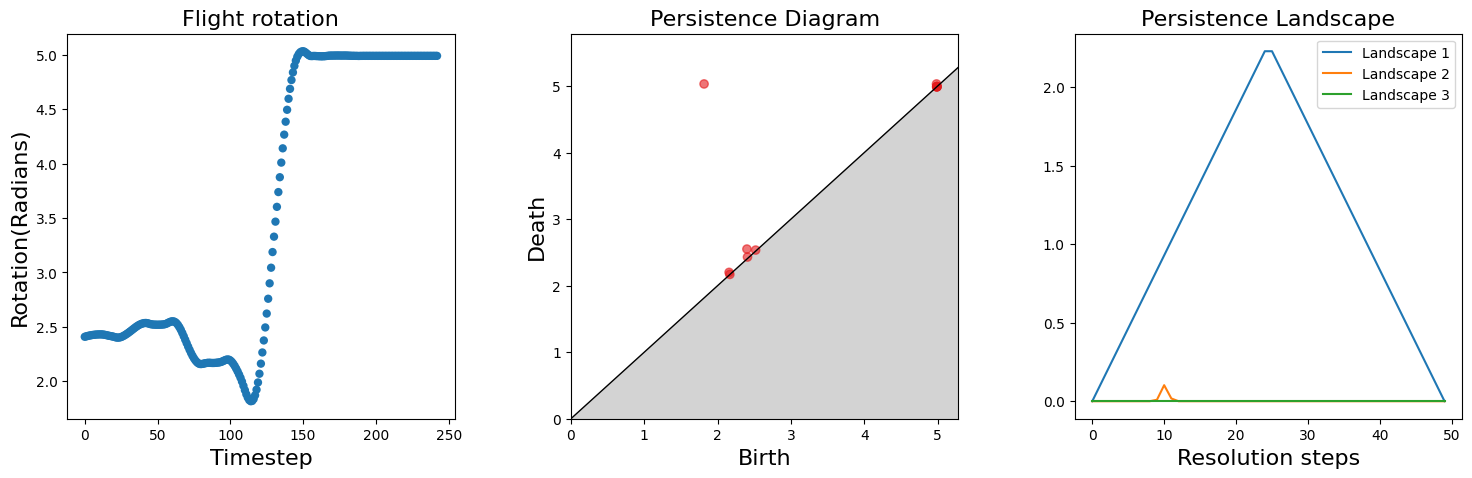

In [71]:
from gudhi.representations import Landscape

index = 200
dataset = 3

pers = pers_train[dataset]
pers.landscape_model = Landscape(num_landscapes=3, resolution=50, keep_endpoints=True)
pers.compute_landscapes()
fig = pers.plot_diagram(index, add_landscape=True)
#fig.savefig("H_example.svg", format="svg", dpi=1000)
pers.landscape_model = Landscape(num_landscapes=3, resolution=20, keep_endpoints=False)
pers.compute_landscapes()
None

In [72]:
def select_model(X, Y, seed, jobs=6):
    models = Models(seed).classifiers if classification else Models(seed).regressors
    kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
    
    trained_models = []
    scores = []

    for i in models.keys():
        model = GridSearchCV(
            models[i][0], 
            models[i][1],
            scoring="balanced_accuracy" if classification else "neg_root_mean_squared_error",
            cv=kfold,
            n_jobs=jobs
        )
        model.fit(X, Y)

        trained_models.append(model.best_estimator_)
        scores.append(model.best_score_)
    
    return trained_models, scores

In [73]:
def prepare_feature_combination(data_dict, feature_names):
    train_features = []
    test_features = []

    for feat_name in feature_names:
        train_feat, test_feat = data_dict[feat_name]
        train_features.append(train_feat.stats if hasattr(train_feat, 'stats') else train_feat)
        test_features.append(test_feat.stats if hasattr(test_feat, 'stats') else test_feat)

    if len(feature_names) != 1:
        X_train = np.concatenate(train_features, axis=1)
        X_test = np.concatenate(test_features, axis=1)
    else:
        X_train = train_features[0]
        X_test = test_features[0]

    return X_train, X_test

In [74]:
seed = 42

feature_combinations = [
    ["B"],
    ["LL"],
    ["A"],
    ["S"],
    ["H"],
    ["LL", "A"],
    ["S", "H"],
    ["LL", "S", "H"],
    ["LL", "A", "S", "H"],
    ["B", "LL", "S", "H"],
    ["B", "LL", "A", "S", "H"]
]

best_models = dict()

for features in feature_combinations:
    features_name = "+".join(features)

    X_train, X_test = prepare_feature_combination(data, features)
    y_train, y_test = prepare_feature_combination(data, ["y"])

    mask = np.logical_and(~np.any(np.isnan(X_train), axis=1), ~np.isnan(y_train))
    X_train = X_train[mask]
    y_train = y_train[mask]

    mask = np.logical_and(~np.any(np.isnan(X_test), axis=1), ~np.isnan(y_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    normalizer = preprocessing.StandardScaler()
    X_train = normalizer.fit_transform(X_train)
    X_test = normalizer.transform(X_test)

    models, scores = select_model(X_train, y_train, seed=seed, jobs=12)
    best_model = models[np.argmax(scores)]

    test_pred = best_model.predict(X_test)
    if classification:
        final_score = balanced_accuracy_score(y_test, test_pred)
    else:
        final_score = root_mean_squared_error(y_test, test_pred)

    best_model_name = str(best_model).split("(")[0]
    best_models[features_name] = (best_model, best_model_name, final_score)
    print(f"{features_name} & {best_model_name} & {final_score:.3f}")

B & RandomForestRegressor & 0.237
LL & RandomForestRegressor & 0.312
A & RandomForestRegressor & 0.264
S & SVR & 0.254
H & RandomForestRegressor & 0.266
LL+A & RandomForestRegressor & 0.257
S+H & RandomForestRegressor & 0.243
LL+S+H & RandomForestRegressor & 0.246
LL+A+S+H & RandomForestRegressor & 0.230
B+LL+S+H & RandomForestRegressor & 0.219
B+LL+A+S+H & RandomForestRegressor & 0.218


In [75]:
scores

[-0.631522266030695,
 -0.27015769858502836,
 -0.297644318544237,
 -0.2604396774797659,
 -0.2444714027027577,
 -0.27030635168795564]

In [76]:
from sklearn.metrics import confusion_matrix, root_mean_squared_error

confusion_matrix(y_val, np.round(prediction))

NameError: name 'y_val' is not defined

In [12]:
identified = np.where(np.logical_and(y_val == 2, np.round(prediction) > 5))

index = indices_val[identified[0]][0]
#index = indices_val[false_negatives[index]]

PersistenceData.plot_multiple_diagrams(pers_objects, index)

IndexError: index 0 is out of bounds for axis 0 with size 0

#### B:          0.992
#### S:          0.948
#### H:          0.982
#### A:          0.949
#### LL:         0.943
#### S+H+A:      0.980
#### LL+S+H+A:   0.984
#### B+LL+S+H+A: 0.994
#### B+H:        0.995
#### B+LL+H      0.995
#### B+LL+S+H    0.996

Where the columns is prediction and the rows are the true value.
i will note that the dataset is not 100% accurate. there are false positives:



The GA detection algorithm sometimes fails to detect GAs either:
* if GAs are initialized early on the approach and have no or only a short climb phase, 
* if GAs have a very tight turn radius and only a short leg on the final approach (as usually performed by small general aviation aircraft), or 
* if GAs directly divert to other airports.

### adding sublevel set height:
this doesnt seem to improve the results, and mostly just confuses the models :/


In [42]:
false_negatives = np.where(np.logical_and(y_val == 2, prediction == 1))[0]
false_positives = np.where(np.logical_and(y_val == 1, prediction == 2))[0]
positives = np.where(y_val == 1)[0]


index = 0
index = indices_val[false_positives[index]]
#index = indices_val[false_negatives[index]]

PersistenceData.plot_multiple_diagrams(pers_objects, index)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
error = np.abs(y_val - prediction)  # Absolute error

# Scatter plot with color based on error
plt.scatter(y_val, prediction, c=error, cmap='plasma')